In [1]:
from pathlib import Path
from itertools import takewhile
import pandas as pd
import numpy as np
from bz2 import decompress

import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='ticks', context='notebook', rc={
    'axes.formatter.useoffset': False,
    
})
%config InlineBackend.figure_format = 'svg'

In [2]:
df = {}
for path in Path('Al.rotated').glob('rot_z_*'):
    # decompress
    cfile = (path/'aims.out.bz2').read_bytes()
    (path/'aims.out').write_text(decompress(cfile).decode())
    
    angle = int(path.name.split('_')[2])
    with (path/'aims.out').open() as f:
        next(l for l in f if l.startswith('Convergence:'))
        lines = list(takewhile(lambda l: l.strip(), f))
        lines = [[float(r[i]) for i in (1, 3, 5, 7, 9)] for r in (l.split() for l in lines)]
    # delete file:
    (path/'aims.out').unlink()
    df[angle] = pd.DataFrame(lines, columns='n q_app density eigen etot'.split()).set_index('n')
df = pd.concat(df, names=['angle'])

def f(x):
    return x.sort_index(ascending=False).etot.cumsum().sort_index().reset_index('angle', drop=True)

df = df.groupby('angle').apply(f).to_frame('ene')

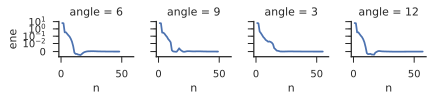

In [3]:
def my_plot(x, y, **kwargs):
    plt.gca().set_yscale('symlog', linthreshy=1e-2)
    plt.plot(x, y, **kwargs)
    
    
g = sns.FacetGrid(
    df.reset_index(),
    col='angle',
    col_wrap=5,
    size=1.5,
    col_order=[ang for ang, _ in sorted(df.groupby('angle'), key=lambda x: len(x[1]))]
)
g.map(my_plot, 'n', 'ene')